In [1]:
!mkdir model
!pip install python-utils

In [2]:
!pip install box2d-py
!pip install gym[Box_2D]

     |████████████████████████████████| 450kB 3.5MB/s 


In [0]:
import gym
import numpy as np
from itertools import count
import os

import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

In [0]:
class Policy(nn.Module):
    def __init__(self, lr, input_dim, l1_dim, l2_dim, actions_num):
        super(Policy, self).__init__()
        self.lr = lr
        self.input_dim = input_dim
        self.l1_dim = l1_dim
        self.l2_dim = l2_dim
        self.actions_num = actions_num
        self.l1 = nn.Linear(*self.input_dim, self.l1_dim)
        self.l2 = nn.Linear(self.l1_dim, self.l2_dim)
        self.l3 = nn.Linear(self.l2_dim, self.actions_num)
        self.optimize = optim.Adam(self.parameters(), lr = lr)
        self.device = T.device('cuda' if T.cuda.is_available() else 'cpu')
        self.to(self.device)
        
        
    def forward(self, observation):
        state = T.Tensor(observation).to(self.device)
        a = F.relu(self.l1(state))
        a = F.relu(self.l2(a))
        a = self.l3(a)
        
        return a

In [0]:
class Agent(object):
    def __init__(self, lr, input_dim, l1_dim, l2_dim, actions_num, gamma):
        self.gamma = gamma
        self.policy = Policy(lr, input_dim, l1_dim, l2_dim, actions_num)
        self.action_mem = []
        self.reward_mem = []
        self.loss = 0
        
    def select_action(self, observation):
        #proobability 
        probs = F.softmax(self.policy.forward(observation))
        action_probs = Categorical(probs)
        action = action_probs.sample()
        log_probs = action_probs.log_prob(action)
        self.action_mem.append(log_probs)
        return action.item()
    
    def learning(self):
        self.policy.optimize.zero_grad()
        G = np.zeros_like(self.reward_mem, dtype=np.float64)
        
        for i in range(len(self.reward_mem)):
            Gsum = 0
            discount = 1
            for j in range(i, len(self.reward_mem)):
                Gsum = Gsum + self.reward_mem[j] * discount
                discount = discount * self.gamma
                
            G[i] = Gsum
            
        #normalize
        mean = np.mean(G)
        std = np.std(G)
        if std <= 0:
            std = 1
        
        G = (G - mean) / std
        
        G = T.tensor(G, dtype=T.float)
        
        #copy to cuda
        G = G.to(self.policy.device)
        
        self.loss = 0
        for i in range(len(G)):
            self.loss +=  -G[i] * self.action_mem[i]
        
        self.loss.backward()
        self.policy.optimize.step()
        
        self.reward_mem = []
        self.action_mem = []
        
        
    def save_weights(self, path):
        T.save(self.policy.state_dict(), path)

In [0]:
import matplotlib.pyplot as plt 
import numpy as np

def plotLearning(scores, filename, x=None, window=5):   
    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
	    running_avg[t] = np.mean(scores[max(0, t-window):(t+1)])
    if x is None:
        x = [i for i in range(N)]
    plt.ylabel('Score')       
    plt.xlabel('Game')                     
    plt.plot(x, running_avg)
    plt.savefig(filename)

In [0]:
env = gym.make('LunarLander-v2')
agent = Agent(lr = 0.001, input_dim = [8], l1_dim = 512, l2_dim = 256, actions_num = 4, gamma = 0.99)

rewards = []
tot_reward = 0
episodes = 2500
if(os.path.exists('./model/weights')):
    agent.policy.load_state_dict(T.load('./model/weights1'))
    print('Loading model')

In [8]:
#train
for i in range(episodes):
    done = False
    tot_reward = 0
    observation = env.reset()
    while not done:
        action = agent.select_action(observation)
        observation_, reward, done, info = env.step(action)
        agent.reward_mem.append(reward)
        observation = observation_
        tot_reward += reward
    rewards.append(tot_reward)
    agent.learning()
    print('episode: ', i,'score: ', tot_reward, 'loss:', agent.loss.item())


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


episode:  0 score:  -123.22790976256269 loss: -0.5192227363586426
episode:  1 score:  -84.3199308177366 loss: 1.290585994720459
episode:  2 score:  -183.7079558930974 loss: -0.033364713191986084
episode:  3 score:  -517.3617680407388 loss: -1.664224624633789
episode:  4 score:  -133.19614388450623 loss: 0.14624500274658203
episode:  5 score:  -177.06557087677936 loss: -3.082751750946045
episode:  6 score:  -216.8016133809711 loss: -2.050971746444702
episode:  7 score:  -104.66046591169894 loss: 7.1771345138549805
episode:  8 score:  -361.47262971475556 loss: -10.37185287475586
episode:  9 score:  -549.4091558142956 loss: -5.809329509735107
episode:  10 score:  -93.84252346103854 loss: -1.8868408203125
episode:  11 score:  -91.93752891462165 loss: 6.327218055725098
episode:  12 score:  -230.1522486982292 loss: 0.7465853691101074
episode:  13 score:  -422.8353471516281 loss: -20.329084396362305
episode:  14 score:  -215.3467256388406 loss: 6.396903038024902
episode:  15 score:  -273.5761

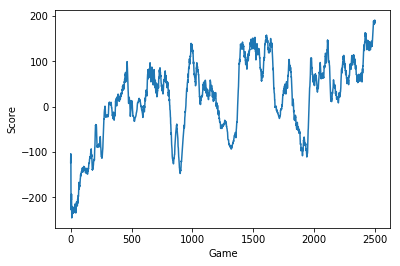

In [9]:
filename = 'lunar-lander-alpha001-128x128fc-newG.png'
plotLearning(rewards, filename=filename, window=25)
T.save(agent.policy.state_dict(), './model/weights')

In [11]:
#testing
episodes = 10
for i in range(episodes):
    done = False
    tot_reward = 0
    observation = env.reset()
    while not done:
        #env.render()
        action = agent.select_action(observation)
        observation_, reward, done, info = env.step(action)
        agent.reward_mem.append(reward)
        observation = observation_
        tot_reward += reward
    rewards.append(tot_reward)
    agent.learning()
    print('episode: ', i,'score: ', tot_reward, 'loss:', agent.loss.item())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


episode:  0 score:  248.62383737102587 loss: 0.9739741683006287
episode:  1 score:  108.38439822121389 loss: -46.338218688964844
episode:  2 score:  40.977718528843646 loss: -79.79330444335938
episode:  3 score:  274.96289397417513 loss: -15.75556468963623
episode:  4 score:  46.4130036963923 loss: -62.9163932800293
episode:  5 score:  213.0221353310816 loss: -99.96002197265625
episode:  6 score:  83.34382037927449 loss: -108.94331359863281
episode:  7 score:  53.74292339699903 loss: -113.63326263427734
episode:  8 score:  65.74229147532108 loss: -59.23405456542969
episode:  9 score:  53.795609455568155 loss: -10.785512924194336
